#Audio Signal Enhancement for Noisy Environments

##Noise Characterization

###Downloading Dependencies

In [ ]:
!pip install pesq

###Import Libraries

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal

###Upload **Audios**

In [ ]:
# prompt: code to upload files

from google.colab import files
uploaded = files.upload()

###Load audio file

In [ ]:
audio_path1 = 'noise_voice.wav'
audio_path2 = 'clean_voice.wav'
y1, sr1 = librosa.load(audio_path1, sr=None)
y2, sr2 = librosa.load(audio_path2, sr=None)

### Step 1: Plot waveform

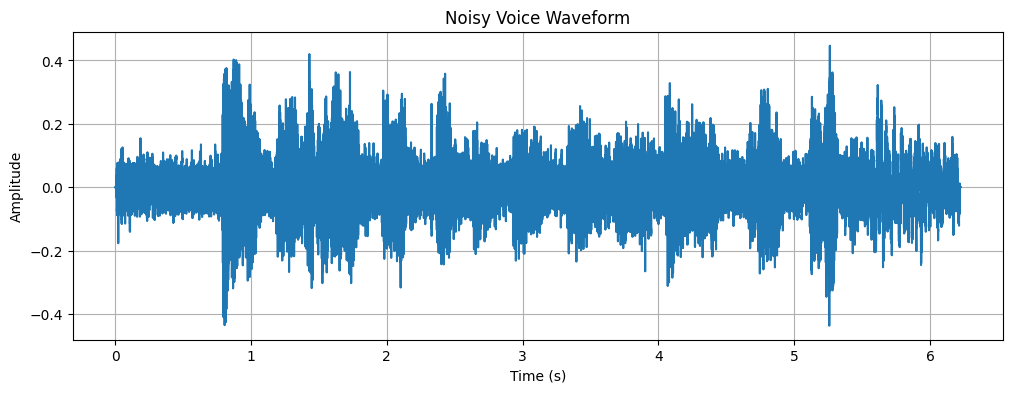

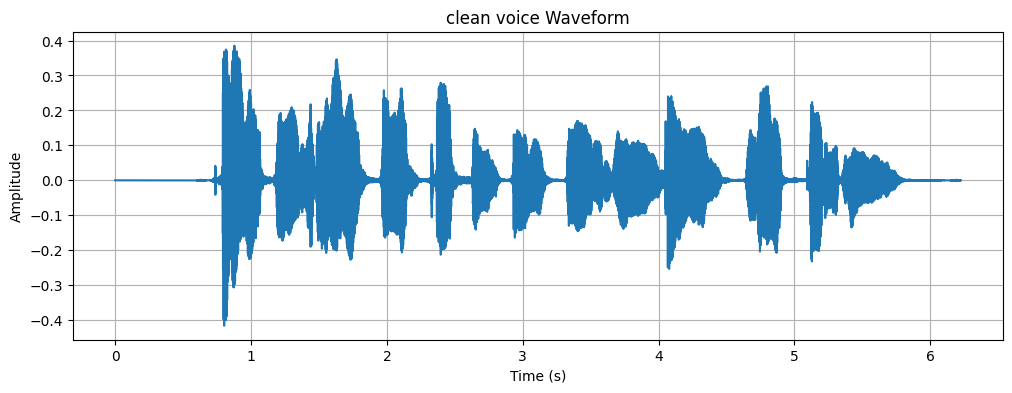

In [ ]:
# mosiy voice
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y1)) / sr1, y1)
plt.title('Noisy Voice Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
plt.close()

# clean voice
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y2)) / sr2, y2)
plt.title('clean voice Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
plt.close()

### Step 2: Compute and plot spectrogram

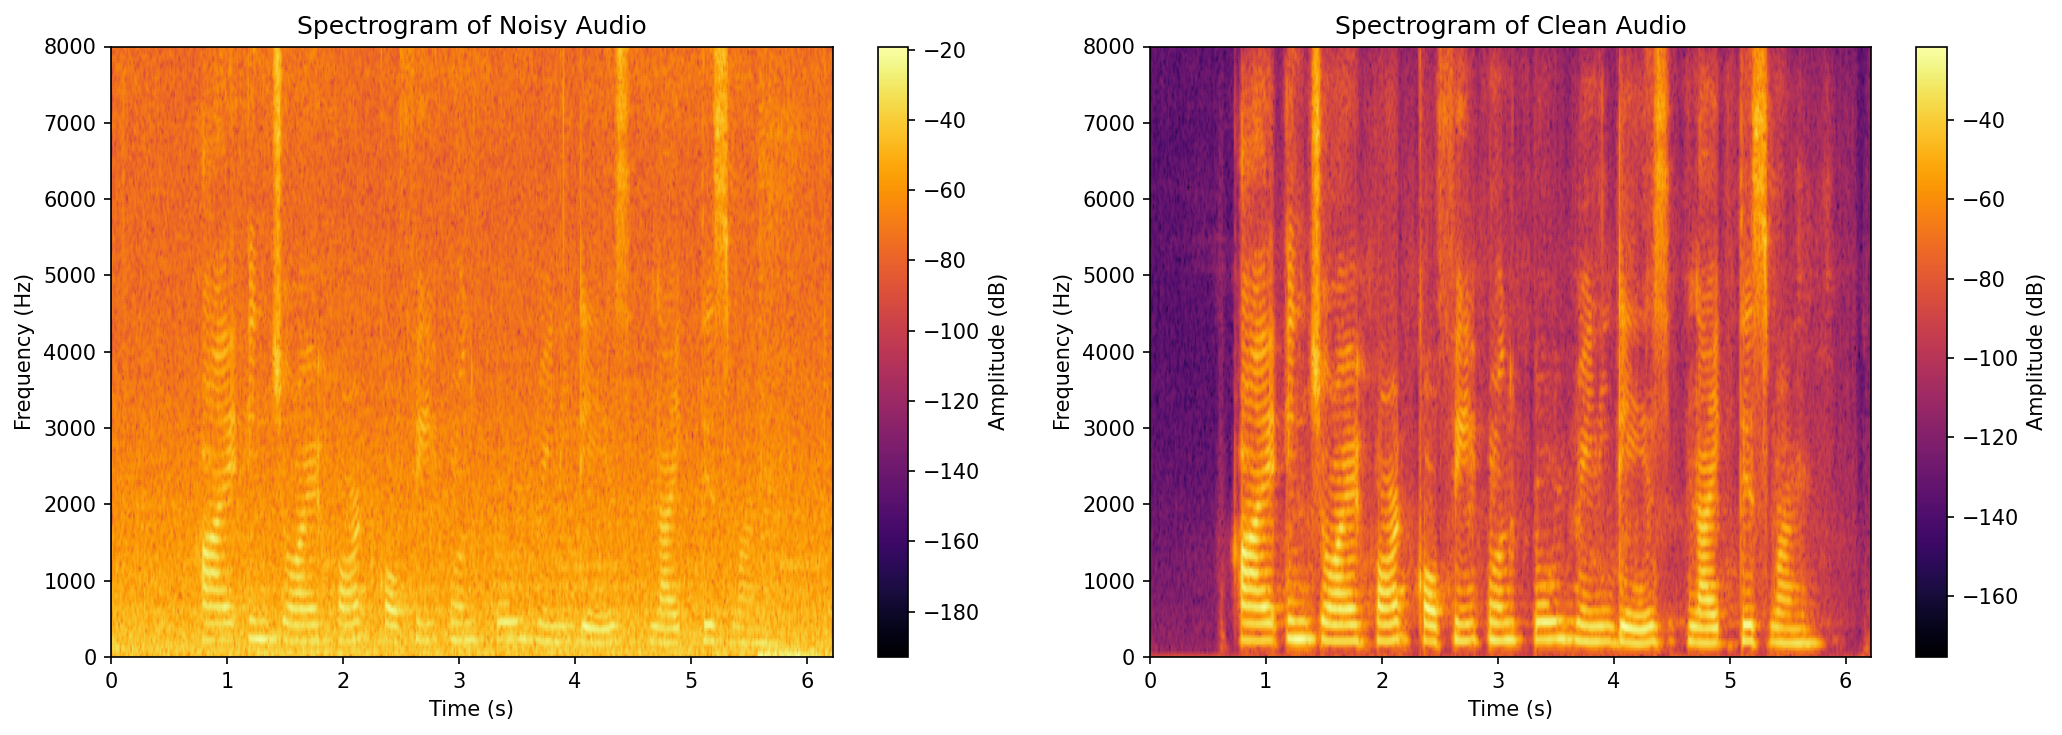

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

plt.figure(figsize=(14, 5), dpi=150)

# --- Spectrogram for Audio 1 (Noisy) ---
f1, t1, Zxx1 = signal.stft(y1, fs=sr1, nperseg=1024)
plt.subplot(1, 2, 1)
plt.pcolormesh(t1, f1, 20 * np.log10(np.abs(Zxx1) + 1e-10), shading='gouraud', cmap='inferno')
plt.title('Spectrogram of Noisy Audio', fontsize=12)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 8000])  # Human hearing range
plt.colorbar(label='Amplitude (dB)')

# --- Spectrogram for Audio 2 (Clean) ---
f2, t2, Zxx2 = signal.stft(y2, fs=sr2, nperseg=1024)
plt.subplot(1, 2, 2)
plt.pcolormesh(t2, f2, 20 * np.log10(np.abs(Zxx2) + 1e-10), shading='gouraud', cmap='inferno')
plt.title('Spectrogram of Clean Audio', fontsize=12)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 8000])
plt.colorbar(label='Amplitude (dB)')

plt.tight_layout()
plt.show()
plt.close()

### Step 3: Estimate and plot noise PSD

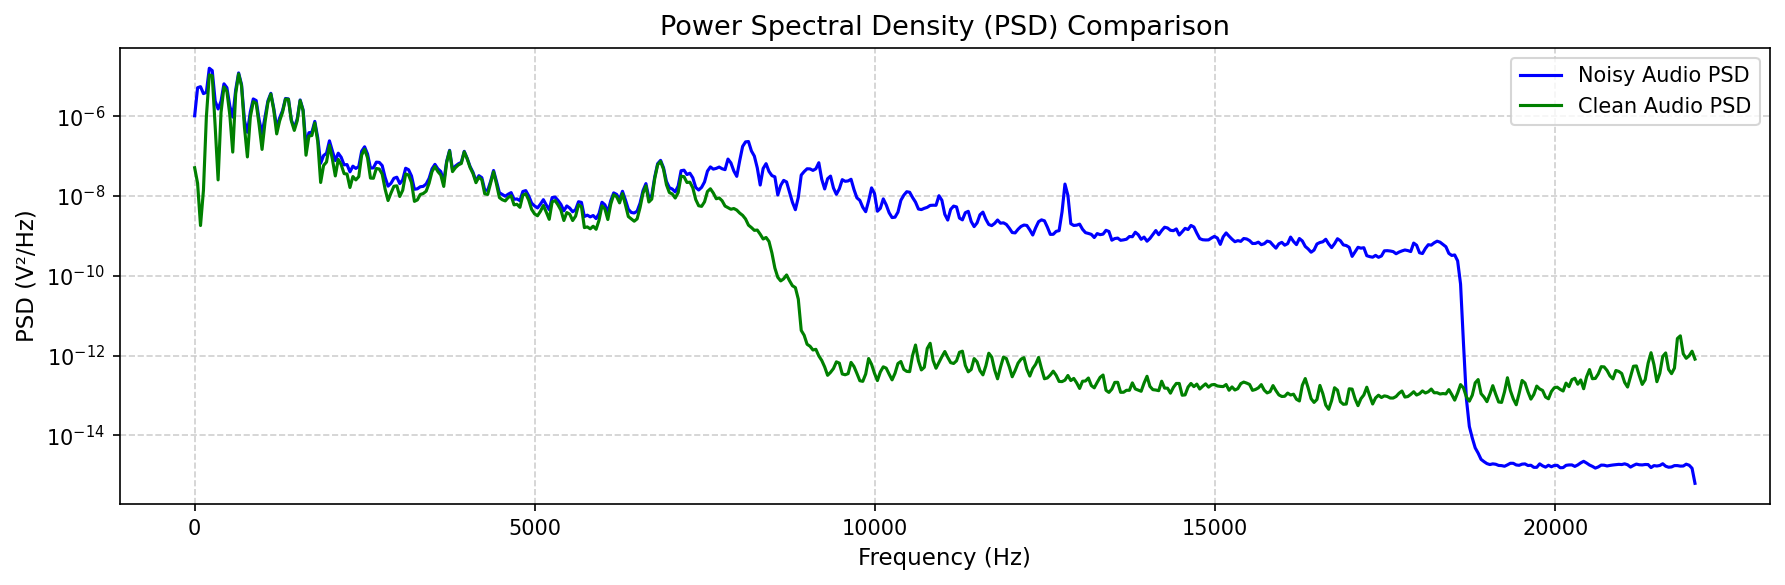

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal

# --- Extract 2-second noise segments ---
noise_segment1 = y1[:int(2.0 * sr1)]
noise_segment2 = y2[:int(2.0 * sr2)]

# --- Compute PSD using Welch's method ---
f_noise1, Pxx_noise1 = signal.welch(noise_segment1, fs=sr1, nperseg=1024)
f_noise2, Pxx_noise2 = signal.welch(noise_segment2, fs=sr2, nperseg=1024)

# --- Plot ---
plt.figure(figsize=(12, 4), dpi=150)
plt.semilogy(f_noise1, Pxx_noise1, label='Noisy Audio PSD', color='blue')
plt.semilogy(f_noise2, Pxx_noise2, label='Clean Audio PSD', color='green')

plt.title('Power Spectral Density (PSD) Comparison', fontsize=13)
plt.xlabel('Frequency (Hz)', fontsize=11)
plt.ylabel('PSD (V²/Hz)', fontsize=11)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

##Algorithm Selection

###Spectral Subtraction

####Apply Spectral Subtraction Filter

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import soundfile as sf

# Load your noisy and clean audio
y_noisy, sr = librosa.load('noise_voice.wav', sr=None)
y_clean, _ = librosa.load('clean_voice.wav', sr=sr)

# STFT of noisy signal
f, t, Zxx = stft(y_noisy, fs=sr, nperseg=1024)

# Estimate noise magnitude from first 0.5 seconds
num_noise_frames = int(0.5 * sr / 512)  # Adjust depending on hop length
noise_magnitude = np.mean(np.abs(Zxx[:, :num_noise_frames]), axis=1, keepdims=True)

# Spectral Subtraction: Subtract noise magnitude from each frame
magnitude = np.abs(Zxx)
phase = np.angle(Zxx)
enhanced_magnitude = np.maximum(magnitude - noise_magnitude, 0)
Zxx_enhanced = enhanced_magnitude * np.exp(1j * phase)

# Inverse STFT to get time-domain signal
_, y_enhanced = istft(Zxx_enhanced, fs=sr, nperseg=1024)


# Save enhanced audio to a WAV file
sf.write('enhanced_spectral_subtraction.wav', y_enhanced, sr)
print("✅ Enhanced audio saved as 'enhanced_spectral_subtraction.wav'")

✅ Enhanced audio saved as 'enhanced_spectral_subtraction.wav'


####Plot Spectrograms

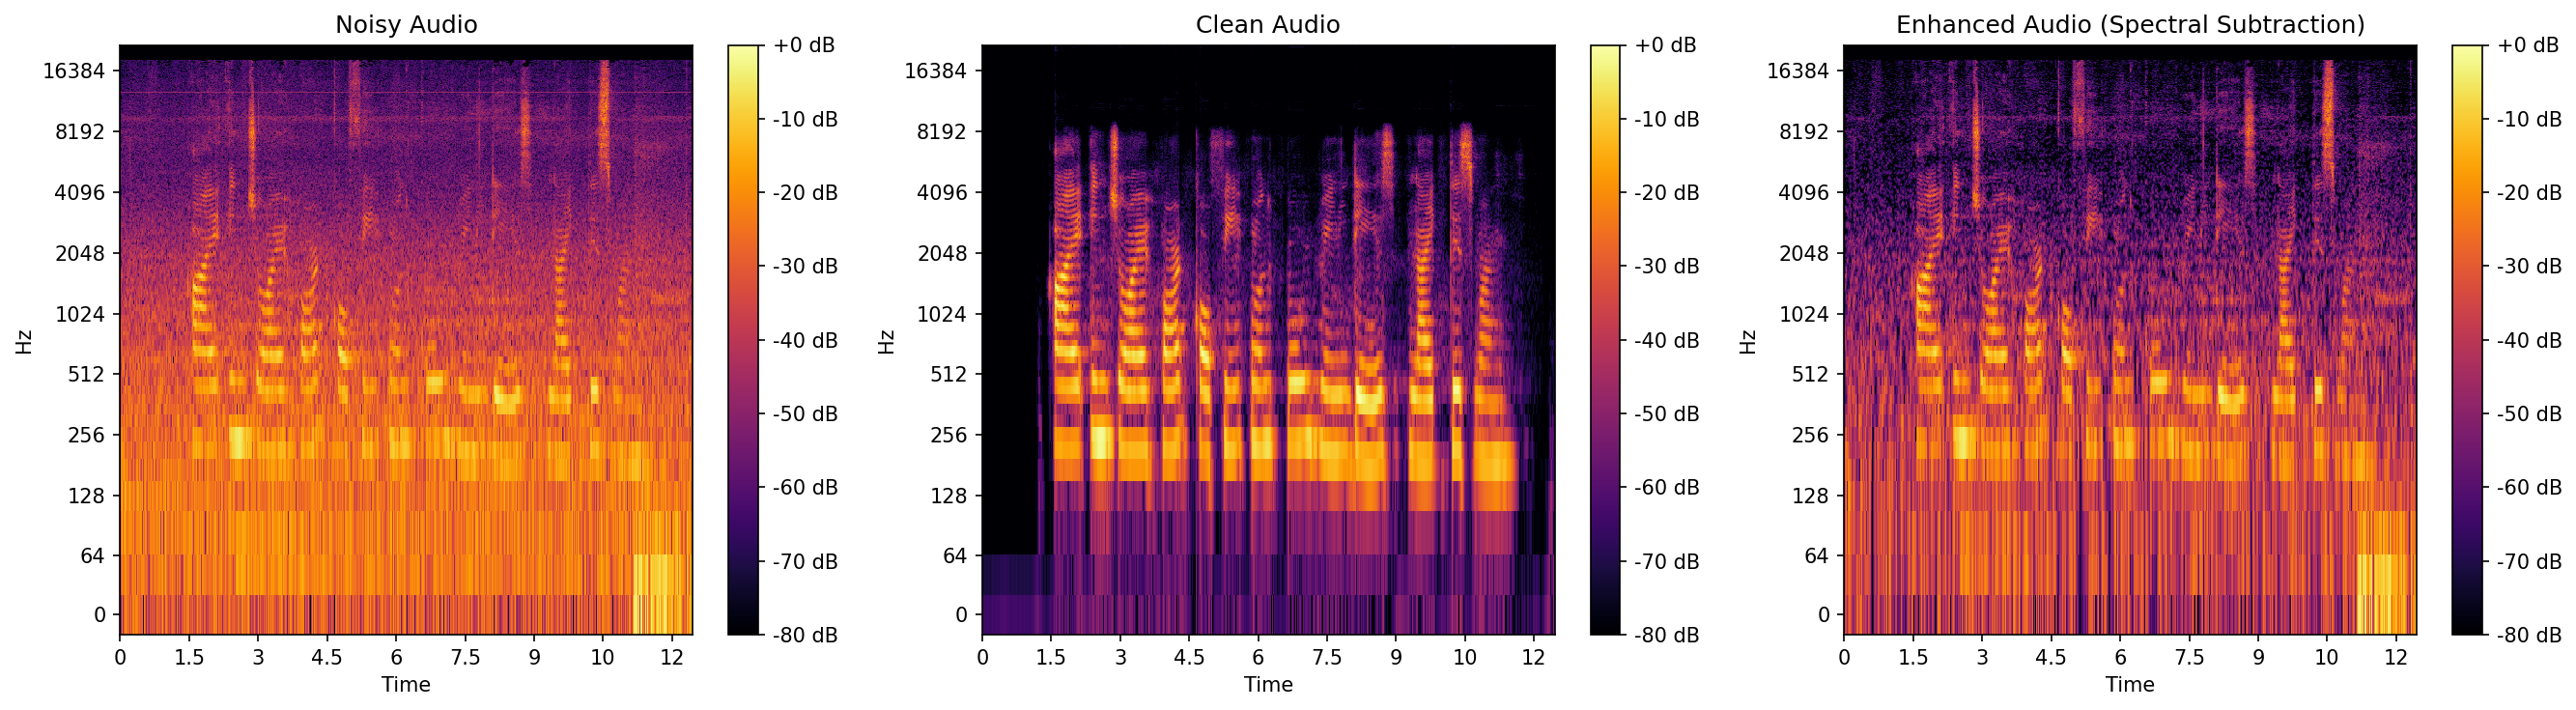

In [ ]:
plt.figure(figsize=(18, 5), dpi=150)

# --- Noisy Audio ---
plt.subplot(1, 3, 1)
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy, n_fft=1024)), ref=np.max)
librosa.display.specshow(D_noisy, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.title('Noisy Audio')
plt.colorbar(format="%+2.0f dB")

# --- Clean Audio ---
plt.subplot(1, 3, 2)
D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(y_clean, n_fft=1024)), ref=np.max)
librosa.display.specshow(D_clean, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.title('Clean Audio')
plt.colorbar(format="%+2.0f dB")

# --- Enhanced Audio (Spectral Subtraction) ---
plt.subplot(1, 3, 3)
D_enhanced = librosa.amplitude_to_db(np.abs(librosa.stft(y_enhanced, n_fft=1024)), ref=np.max)
librosa.display.specshow(D_enhanced, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.title('Enhanced Audio (Spectral Subtraction)')
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()

##Performance Evaluation

###SNR

####SNR Function

In [11]:
import numpy as np

def compute_snr(reference, test):
    noise = reference - test
    signal_power = np.mean(reference ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

####Compute SNR Values

In [12]:
snr_noisy = compute_snr(y_clean, y_noisy)
snr_enhanced = compute_snr(y_clean, y_enhanced)

print(f"SNR (Noisy): {snr_noisy:.2f} dB")
print(f"SNR (Enhanced): {snr_enhanced:.2f} dB")

SNR (Noisy): 1.85 dB
SNR (Enhanced): 5.70 dB


####Plot SNR Comparison

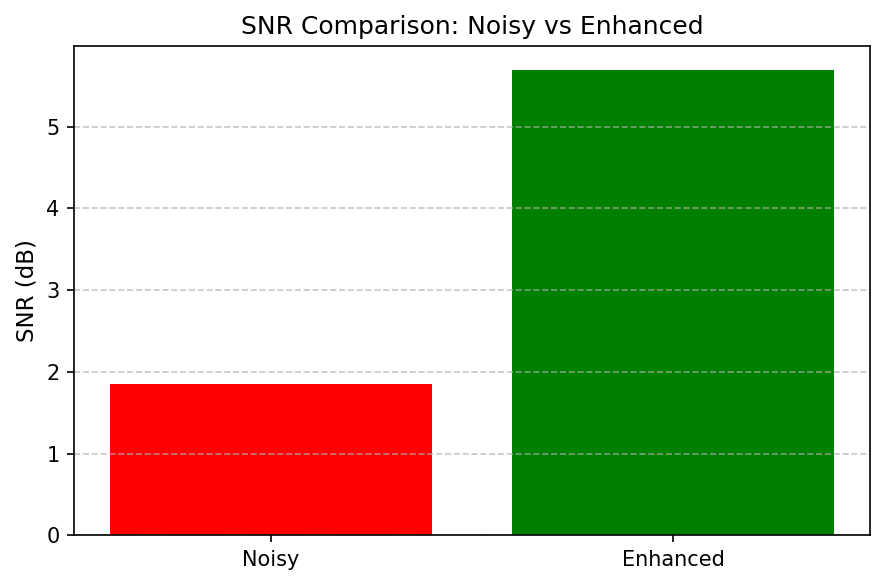

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)
plt.bar(['Noisy', 'Enhanced'], [snr_noisy, snr_enhanced], color=['red', 'green'])
plt.title('SNR Comparison: Noisy vs Enhanced', fontsize=12)
plt.ylabel('SNR (dB)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

###PESQ (Perceptual Evaluation of Speech Quality)

####Code to Compute PESQ

In [14]:
from pesq import pesq
from scipy.signal import resample

# Make sure both signals are the same length and sampling rate
min_len = min(len(y_clean), len(y_enhanced))
y_clean_aligned = y_clean[:min_len]
y_enhanced_aligned = y_enhanced[:min_len]

# PESQ requires 16 kHz for wideband
if sr != 16000:
    y_clean_aligned = resample(y_clean_aligned, int(len(y_clean_aligned) * 16000 / sr))
    y_enhanced_aligned = resample(y_enhanced_aligned, int(len(y_enhanced_aligned) * 16000 / sr))
    sr = 16000

# Compute PESQ (wideband mode)
pesq_score = pesq(sr, y_clean_aligned, y_enhanced_aligned, 'wb')
print(f"PESQ Score (Enhanced): {pesq_score:.2f}")

PESQ Score (Enhanced): 1.30


###MOS

####Calculate the MOS

In [15]:
# Example: MOS scores collected
noisy_scores = [2, 1, 2, 3, 2]
enhanced_scores = [3, 3, 4, 4, 3]

mos_noisy = sum(noisy_scores) / len(noisy_scores)
mos_enhanced = sum(enhanced_scores) / len(enhanced_scores)

print(f"MOS (Noisy): {mos_noisy:.2f}")
print(f"MOS (Enhanced): {mos_enhanced:.2f}")

MOS (Noisy): 2.00
MOS (Enhanced): 3.40


####Visualize the Results

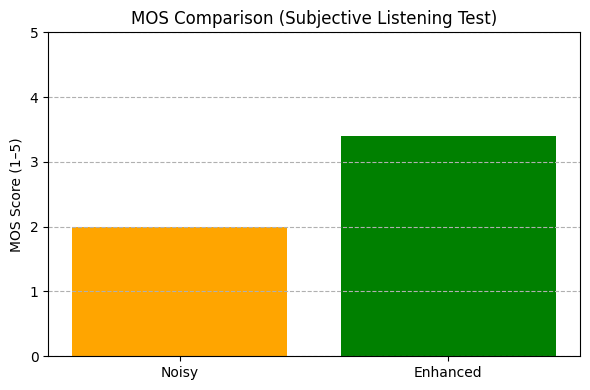

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(['Noisy', 'Enhanced'], [mos_noisy, mos_enhanced], color=['orange', 'green'])
plt.title('MOS Comparison (Subjective Listening Test)')
plt.ylabel('MOS Score (1–5)')
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()